In [ ]:
import pandas as pd
import kagglehub
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

2025-05-18 09:50:03.464397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747561803.686313      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747561803.750519      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Loading dataset

In [3]:
df=pd.read_csv('/kaggle/input/fakenews1/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# 2. Pre-processing 

# 2.1 Dropping NA values and resetting index

In [4]:
df = df.dropna().reset_index(drop=True)

In [ ]:
#splitting input features and output label
X=df.drop('label',axis=1)

In [6]:
y=df['label']
y.value_counts()

label
0    10361
1     7924
Name: count, dtype: int64

In [7]:
X.shape

(18285, 4)

In [8]:
y.shape

(18285,)

# 2.2 Adding author name after stemming title (New feature)

In [9]:
ps = PorterStemmer()
corpus = []
for i in range(len(X)):
    title = re.sub('[^a-zA-Z]', ' ', X['title'][i])
    title = title.lower()
    title = title.split()
    title = [ps.stem(word) for word in title if word not in stopwords.words('english')]
    title = ' '.join(title 
    
    author = df['author'][i]  # raw author
    content = author + " " + title
    corpus.append(content)


In [10]:
corpus

['Darrell Lucus hous dem aid even see comey letter jason chaffetz tweet',
 'Daniel J. Flynn flynn hillari clinton big woman campu breitbart',
 'Consortiumnews.com truth might get fire',
 'Jessica Purkiss civilian kill singl us airstrik identifi',
 'Howard Portnoy iranian woman jail fiction unpublish stori woman stone death adulteri',
 'Daniel Nussbaum jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'Alissa J. Rubin beno hamon win french socialist parti presidenti nomin new york time',
 'Megan Twohey and Scott Shane back channel plan ukrain russia courtesi trump associ new york time',
 'Aaron Klein obama organ action partner soro link indivis disrupt trump agenda',
 'Chris Tomlinson bbc comedi sketch real housew isi caus outrag',
 'Amando Flavio russian research discov secret nazi militari base treasur hunter arctic photo',
 'Jason Ditz us offici see link trump russia',
 'AnotherAnnie ye paid govern troll social media blog forum websi

# 2.3 Creating one-hot representations

In [11]:
voc_size=5000

In [12]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr[:10]

[[1676, 1703, 1774, 3935, 539, 4755, 976, 2344, 2237, 1952, 2998, 360],
 [2244, 2605, 456, 456, 2066, 2980, 4630, 2488, 1768, 3408],
 [1070, 4509, 964, 3662, 901, 1446],
 [1484, 4027, 255, 611, 4690, 4646, 811, 327],
 [1413, 2368, 1564, 2488, 935, 330, 693, 4391, 2488, 2562, 405, 2574],
 [2244,
  165,
  2492,
  4847,
  4252,
  2007,
  3218,
  364,
  3353,
  3902,
  4419,
  3465,
  3130,
  4483,
  493,
  2661,
  3408],
 [3987,
  2605,
  3505,
  1508,
  3884,
  2376,
  3133,
  153,
  1415,
  419,
  289,
  1395,
  4735,
  4796],
 [275,
  730,
  3303,
  91,
  3533,
  3518,
  2733,
  1971,
  2894,
  2985,
  272,
  364,
  4852,
  1395,
  4735,
  4796],
 [2443, 3770, 3768, 4557, 1175, 2917, 1952, 1892, 3545, 876, 364, 1813],
 [430, 1732, 3334, 3901, 1317, 4627, 4862, 1323, 3066, 3388]]

In [13]:
#static embeddings
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 1952 2998  360]
 [   0    0    0 ... 2488 1768 3408]
 [   0    0    0 ... 3662  901 1446]
 ...
 [   0    0 3894 ... 1395 4735 4796]
 [   0    0    0 ... 2024 2503 1366]
 [   0    0    0 ... 2348  610  952]]


In [14]:
embedded_docs[0] #single message, embedded

array([   0,    0,    0,    0,    0,    0,    0,    0, 1676, 1703, 1774,
       3935,  539, 4755,  976, 2344, 2237, 1952, 2998,  360], dtype=int32)

In [15]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

# 3. Models

# 3.1 Just LSTM

In [16]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-12 15:34:04.330409: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# 3.2 Bi-LSTM

In [17]:
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
embedding_vector_features=70
model2=Sequential()
model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model2.add(Bidirectional(LSTM(200)))
model2.add(Dropout(0.4))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# 4. Training

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [20]:
LSTM1 = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) ## Just LSTM

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8133 - loss: 0.3830 - val_accuracy: 0.9702 - val_loss: 0.1151
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9887 - loss: 0.0427 - val_accuracy: 0.9889 - val_loss: 0.0409
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9973 - loss: 0.0118 - val_accuracy: 0.9904 - val_loss: 0.0356
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9977 - loss: 0.0089 - val_accuracy: 0.9856 - val_loss: 0.0521
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9985 - loss: 0.0044 - val_accuracy: 0.9896 - val_loss: 0.0408
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9894 - val_loss: 0.0494
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9843 - val_loss: 0.0639
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9981 - loss: 0.0055 - val_accu

In [21]:
BiLSTM1= model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) ## Bi-LSTM with 100 nodes, and 40 emedding features

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.8141 - loss: 0.3589 - val_accuracy: 0.9720 - val_loss: 0.0797
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9919 - loss: 0.0258 - val_accuracy: 0.9780 - val_loss: 0.0691
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9953 - loss: 0.0168 - val_accuracy: 0.9834 - val_loss: 0.0580
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.9811 - val_loss: 0.0792
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9824 - val_loss: 0.0727
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9755 - val_loss: 0.1025
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9838 - val_loss: 0.0823
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 1.3180e-04 - val

In [22]:
BiLSTM2= model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64) ## Bi-LSTM with 200 nodes, and 70 emedding features

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.8424 - loss: 0.3162 - val_accuracy: 0.9803 - val_loss: 0.0599
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9927 - loss: 0.0272 - val_accuracy: 0.9814 - val_loss: 0.0568
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9972 - loss: 0.0118 - val_accuracy: 0.9818 - val_loss: 0.0613
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9982 - loss: 0.0101 - val_accuracy: 0.9838 - val_loss: 0.0714
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9848 - val_loss: 0.0658
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9809 - val_loss: 0.0799
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9881 - val_loss: 0.0518
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9994 - loss: 0.0022 - 

# 5. Evaluation

# # Just LSTM

In [23]:
#Just LSTM
#Accuracy
y_pred = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3419
           1       0.99      0.98      0.99      2616

    accuracy                           0.99      6035
   macro avg       0.99      0.99      0.99      6035
weighted avg       0.99      0.99      0.99      6035

Confusion Matrix:
[[3404   15]
 [  45 2571]]


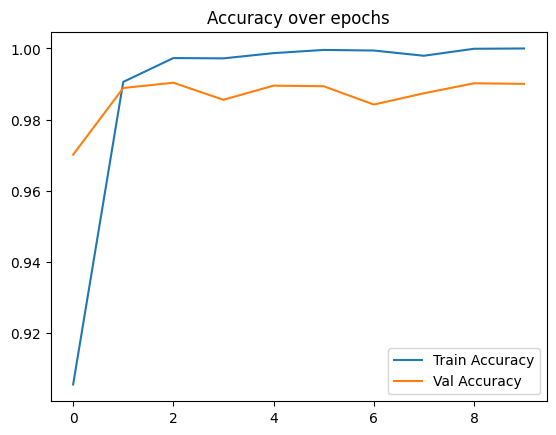

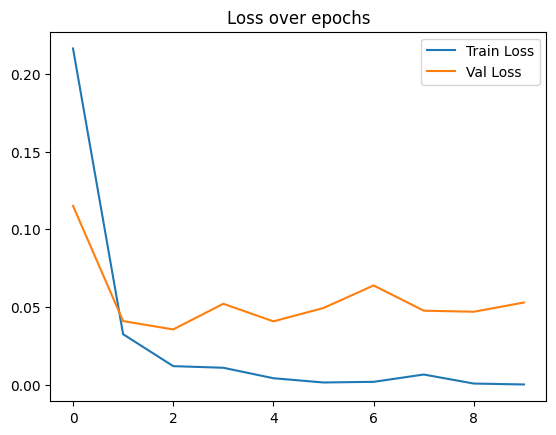

In [24]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(LSTM1.history['accuracy'], label='Train Accuracy')
plt.plot(LSTM1.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Loss
plt.plot(LSTM1.history['loss'], label='Train Loss')
plt.plot(LSTM1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()


# #Bi-LSTM 

In [25]:
#BiBiLSTM1
#Accuracy
y_pred = (model1.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3419
           1       0.98      0.98      0.98      2616

    accuracy                           0.98      6035
   macro avg       0.98      0.98      0.98      6035
weighted avg       0.98      0.98      0.98      6035

Confusion Matrix:
[[3378   41]
 [  62 2554]]


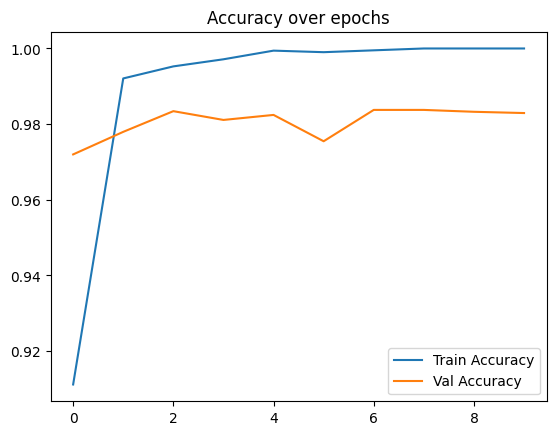

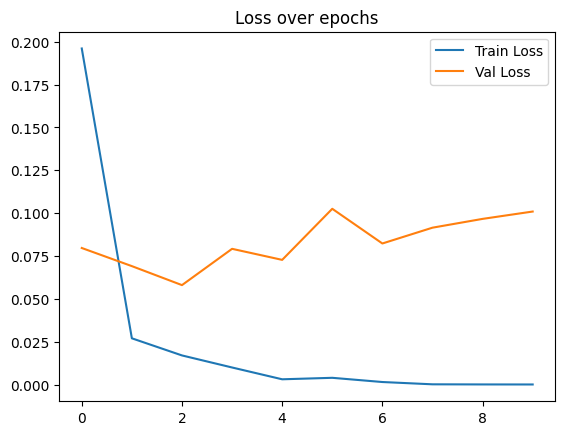

In [26]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(BiLSTM1.history['accuracy'], label='Train Accuracy')
plt.plot(BiLSTM1.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Loss
plt.plot(BiLSTM1.history['loss'], label='Train Loss')
plt.plot(BiLSTM1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()


In [33]:
embedding_vector_features=1000
model5=Sequential()
model5.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model5.add(Bidirectional(LSTM(70)))
model5.add(Dropout(0.1))
model5.add(Dense(1,activation='sigmoid'))
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 20, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 939,005 (3.58 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,004 (2.39 MB)

None
